In [2]:
import os
import glob
import librosa
import numpy as np
import soundfile as sf
import subprocess
import os

#BACK TO WAV?
#test mp3compression
#0->best
#4->perceptual transparency
#6->acceptable
#8->bad

def mp3towav(input, output):
    subprocess.run(["ffmpeg", "-y", "-loglevel", "quiet", "-i", input, "-ar", "16000", output], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

def mp3compression(inputfile, outputfile, quality=4):
    auxoutputfile = inputfile.split('.')[0] + "_" + str(quality) + ".mp3"
    subprocess.run(["ffmpeg", "-y", "-loglevel", "quiet", "-i", inputfile, "-codec:a", "libmp3lame", "-q:a", str(quality), auxoutputfile], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    
    if os.path.exists(outputfile):
        os.remove(outputfile)

    mp3towav(auxoutputfile, outputfile)
    
    if os.path.exists(auxoutputfile):
        os.remove(auxoutputfile)

    print("MP3 COMPRESSION COMPLETED with VBR quality: " + str(quality))


input_folder = 'lt400'
output_folder = 'output_folder'
quality_values = [ 0, 4, 6, 9]

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

for desired_quality in quality_values:
    output_folder = os.path.join(output_folder, f'quality{desired_quality}')
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for file in glob.glob(os.path.join(input_folder, '*.wav')):
        output_filename = os.path.join(output_folder, os.path.basename(file))
        mp3compression(file, output_filename, desired_quality)

        

MP3 COMPRESSION COMPLETED with VBR quality: 0
MP3 COMPRESSION COMPLETED with VBR quality: 0
MP3 COMPRESSION COMPLETED with VBR quality: 0
MP3 COMPRESSION COMPLETED with VBR quality: 0
MP3 COMPRESSION COMPLETED with VBR quality: 0
MP3 COMPRESSION COMPLETED with VBR quality: 0
MP3 COMPRESSION COMPLETED with VBR quality: 0
MP3 COMPRESSION COMPLETED with VBR quality: 0
MP3 COMPRESSION COMPLETED with VBR quality: 0
MP3 COMPRESSION COMPLETED with VBR quality: 0
MP3 COMPRESSION COMPLETED with VBR quality: 0
MP3 COMPRESSION COMPLETED with VBR quality: 0
MP3 COMPRESSION COMPLETED with VBR quality: 0
MP3 COMPRESSION COMPLETED with VBR quality: 0
MP3 COMPRESSION COMPLETED with VBR quality: 0
MP3 COMPRESSION COMPLETED with VBR quality: 0
MP3 COMPRESSION COMPLETED with VBR quality: 0
MP3 COMPRESSION COMPLETED with VBR quality: 0
MP3 COMPRESSION COMPLETED with VBR quality: 0
MP3 COMPRESSION COMPLETED with VBR quality: 0
MP3 COMPRESSION COMPLETED with VBR quality: 0
MP3 COMPRESSION COMPLETED with VBR

In [3]:
import os
import json
import wave
import sys
import json
from vosk import Model, KaldiRecognizer, SetLogLevel
import pandas as pd

def transcribe_files_to_tsv(input_folder, output_filename):
    # Set the log level to 0 to disable debug messages
    SetLogLevel(0)

    model = Model(lang="ca")
    transcriptions = []

    # Iterate through all files in the input folder
    for file in os.listdir(input_folder):
        #print(os.path.basename(file))
        if file.endswith(".wav"):
            wf = wave.open(os.path.join(input_folder, file), "rb")
            if wf.getnchannels() != 1 or wf.getsampwidth() != 2 or wf.getcomptype() != "NONE":
                print(f"Audio file {file} must be WAV format mono PCM.")
                continue

            rec = KaldiRecognizer(model, wf.getframerate())
            rec.SetWords(True)
            rec.SetPartialWords(True)

            # Process the audio file
            last = None
            while True:
                data = wf.readframes(4000)
                if len(data) == 0:
                    break      
                if rec.AcceptWaveform(data):
                    last = rec.Result()
                else:
                    rec.PartialResult()             
                #if rec.AcceptWaveform(data):
                    
            result_json = rec.Result()
            result_dict = json.loads(result_json)
            if(result_dict["text"] == ""):
                try:
                    result_dict = json.loads(last)   
                except:
                    print("Error") 
            #results = result_dict["result"]
            #print(os.path.basename(file)+"saved")
            transcriptions.append((os.path.basename(file), result_dict["text"]))
            #print(result_dict["text"])
                    

    # Convert the list of transcriptions to a DataFrame
    transcriptions_df = pd.DataFrame(transcriptions, columns=['filename', 'transcription'])

    # Save the output to a TSV file
    transcriptions_df.to_csv(output_filename, sep="\t", index=False)


import csv
from pathlib import Path
from jiwer import wer
from torchmetrics.functional.audio.pesq import perceptual_evaluation_speech_quality
from scipy.io import wavfile
import warnings
from pesq import cypesq
import torch
import librosa

# Suppress the specific warning messages
warnings.filterwarnings("ignore", message="To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).")

def read_audio_file(file_path):
    data, fs = librosa.load(file_path, sr=16000)
    data = torch.tensor(data, dtype=torch.float32)
    return fs, data

def calculate_pesq(fs, ref_audio, deg_audio, mode):
    # Detach the tensors from the computation graph and move them to the CPU
    ref_audio_detached = ref_audio.detach().cpu()
    deg_audio_detached = deg_audio.detach().cpu()
    
    try:
        # Call the perceptual_evaluation_speech_quality function with PyTorch tensors
        return perceptual_evaluation_speech_quality(ref_audio_detached, deg_audio_detached, fs, mode)
    except cypesq.NoUtterancesError:
        print("No utterances detected in the input audio files.")
        return 1

def pesq_from_paths(ref_file_path, deg_file_path):
    fs_ref, ref_audio = read_audio_file(ref_file_path)
    fs_deg, deg_audio = read_audio_file(deg_file_path)
    # Ensure the sampling frequencies are the same
    assert fs_ref == fs_deg, "Sampling frequencies must be the same" + str(fs_ref) + str(fs_deg)

    # Choose the mode based on the sampling frequency
    mode = 'wb' if fs_ref == 16000 else 'nb'

    if len(ref_audio) > len(deg_audio):
        pad_length = len(ref_audio) - len(deg_audio)
        deg_audio = torch.cat([deg_audio, torch.zeros(pad_length, dtype=torch.float32)])
    elif len(ref_audio) < len(deg_audio):
        deg_audio = deg_audio[:len(ref_audio)]

    # Calculate PESQ score
    pesq_score = calculate_pesq(fs_ref, ref_audio, deg_audio, mode)
    return pesq_score

def read_tsv_file(tsv_file_path):
    # Read the TSV file and store its contents in a dictionary
    tsv_data = {}

    with open(tsv_file_path, "r") as file:
        tsv_file = csv.reader(file, delimiter="\t")
        next(tsv_file)  # Skip header row
        for line in tsv_file:
            if len(line) == 2:
                filename, transcription = line
                tsv_data[filename] = {
                    "transcription": transcription
                }
            else:
                print(f"Skipping line with unexpected number of values: {line}")

    return tsv_data

def calculate_wer_pesq(original_data, augmented_data, output_file_path, quality):
    # Calculate WER and PESQ for each file
    output = []
    for filename, data in original_data.items():
        original_transcription = data["transcription"]
        if filename in augmented_data:
            augmented_transcription = augmented_data[filename]["transcription"]
            ref_file_path = f"{ORIGINAL_FOLDER}/{filename}"
            deg_file_path = f"{augmented_folder}/{filename}"
            print(ref_file_path + "  " + deg_file_path)
            try:
                wer_score = wer(original_transcription, augmented_transcription)
            except:
                wer_score = 1
            pesq_score = pesq_from_paths(ref_file_path, deg_file_path)
            #print("PESQ "+ str(pesq_score)+"WER "+str(wer_score))
            output.append([filename, wer_score, str(pesq_score).replace("tensor(", "").replace(")", ""), quality])
        else:
            print(f"No augmented transcription found for file {filename}")
    # Save the output to a TSV file
    with open(output_file_path, "w", newline="") as file:
        writer = csv.writer(file, delimiter="\t")
        writer.writerow(["Filename", "WER", "PESQ", "quality"])
        writer.writerows(output)



#transcribe_files_to_tsv("lt400/", "lt400.tsv")
transcribe_files_to_tsv("quality0/", os.path.join("quality0", "quality0.tsv"))
transcribe_files_to_tsv("quality4/", os.path.join("quality4", "quality4.tsv"))
transcribe_files_to_tsv("quality6/", os.path.join("quality6", "quality6.tsv"))
transcribe_files_to_tsv("quality9/", os.path.join("quality9", "quality9.tsv"))

ORIGINAL_FOLDER = "lt400"


tsvoriginal_file_path = Path("lt400/lt400.tsv")
tsv_data = read_tsv_file(tsvoriginal_file_path)


augmented_folder = "quality0"
quality05_path = Path("quality0/quality0.tsv")
quality05 = read_tsv_file(quality05_path)
output_quality05 = Path("OUTPUT0quality.tsv")

calculate_wer_pesq(tsv_data, quality05, output_quality05,0)

augmented_folder = "quality4"
quality10_path = Path("quality4/quality4.tsv")
quality10 = read_tsv_file(quality10_path)
output_quality10 = Path("OUTPUT04quality.tsv")

calculate_wer_pesq(tsv_data, quality10, output_quality10,4)


augmented_folder = "quality6"
quality20_path = Path("quality6/quality6.tsv")
quality20 = read_tsv_file(quality20_path)
output_quality20 = Path("OUTPUT6quality.tsv")

calculate_wer_pesq(tsv_data, quality20, output_quality20,6)

augmented_folder = "quality9"
quality30_path = Path("quality9/quality9.tsv")
quality30 = read_tsv_file(quality30_path)
output_quality30 = Path("OUTPUT9quality.tsv")

calculate_wer_pesq(tsv_data, quality30, output_quality30,9)



/home/lucastakanori/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
LOG (VoskAPI:ReadDataFiles():model.cc:213) Decoding params beam=10 max-active=3000 lattice-beam=2
LOG (VoskAPI:ReadDataFiles():model.cc:216) Silence phones 1:2:3:4:5:6:7:8:9:10
LOG (VoskAPI:RemoveOrphanNodes():nnet-nnet.cc:948) Removed 1 orphan nodes.
LOG (VoskAPI:RemoveOrphanComponents():nnet-nnet.cc:847) Removing 2 orphan components.
LOG (VoskAPI:Collapse():nnet-utils.cc:1488) Added 1 components, removed 2
LOG (VoskAPI:ReadDataFiles():model.cc:248) Loading i-vector extractor from /home/lucastakanori/.cache/vosk/vosk-model-small-ca-0.4/ivector/final.ie
LOG (VoskAPI:ComputeDerivedVars():ivector-extractor.cc:183) Computing derived variables for iVector extractor
LOG (VoskAPI:ComputeDerivedVars():ivector-extractor.cc:204) Done.
LOG

Error


WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc

lt400/common_voice_ca_31378986.wav  quality0/common_voice_ca_31378986.wav
lt400/common_voice_ca_31340819.wav  quality0/common_voice_ca_31340819.wav
lt400/upc_ca_pau_101129.wav  quality0/upc_ca_pau_101129.wav
lt400/upc_ca_pau_101059.wav  quality0/upc_ca_pau_101059.wav
lt400/common_voice_ca_31169713.wav  quality0/common_voice_ca_31169713.wav
lt400/common_voice_ca_30791849.wav  quality0/common_voice_ca_30791849.wav
lt400/common_voice_ca_31083166.wav  quality0/common_voice_ca_31083166.wav
lt400/common_voice_ca_31792858.wav  quality0/common_voice_ca_31792858.wav
lt400/upc_ca_pau_101070.wav  quality0/upc_ca_pau_101070.wav
lt400/common_voice_ca_31148020.wav  quality0/common_voice_ca_31148020.wav
lt400/upc_ca_pau_101022.wav  quality0/upc_ca_pau_101022.wav
lt400/common_voice_ca_31480904.wav  quality0/common_voice_ca_31480904.wav
lt400/upc_ca_ona_100029.wav  quality0/upc_ca_ona_100029.wav
lt400/common_voice_ca_30957869.wav  quality0/common_voice_ca_30957869.wav
lt400/upc_ca_ona_100072.wav  quali

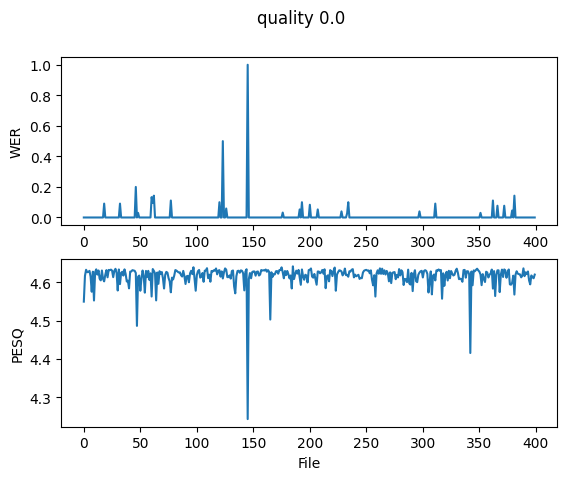

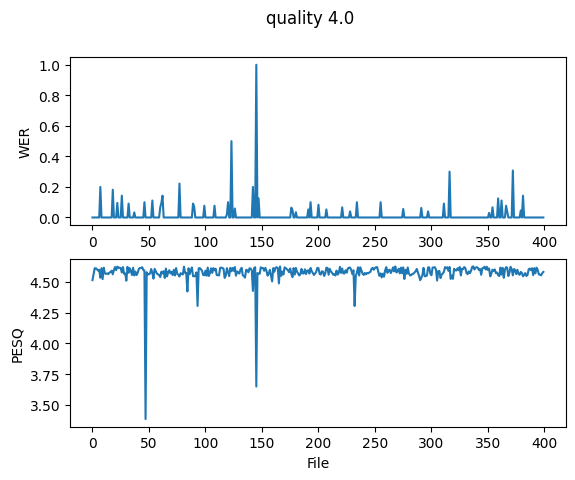

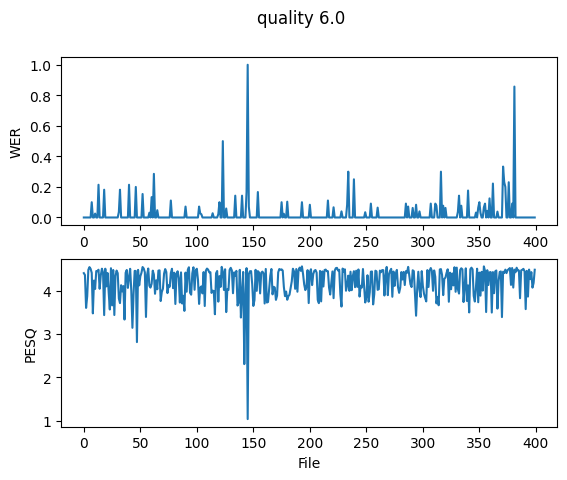

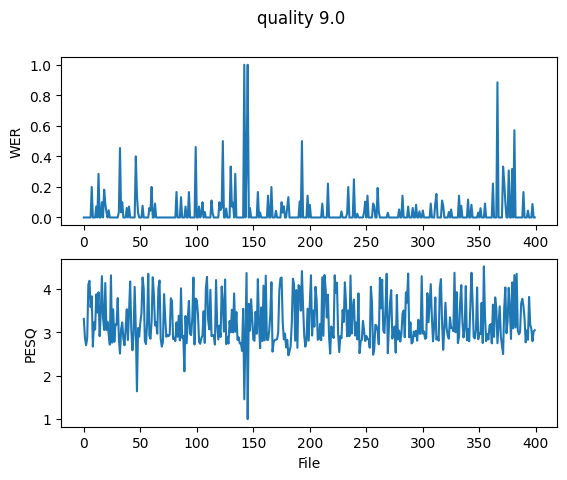

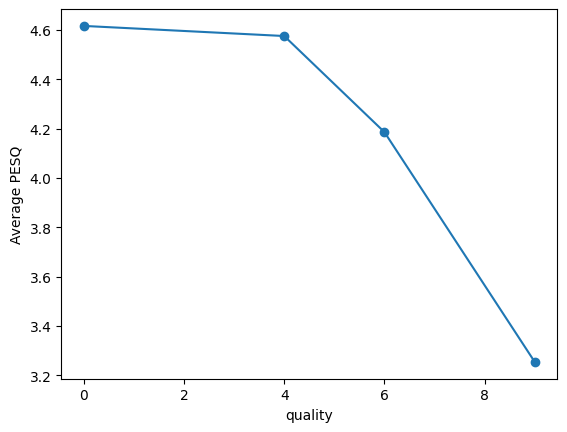

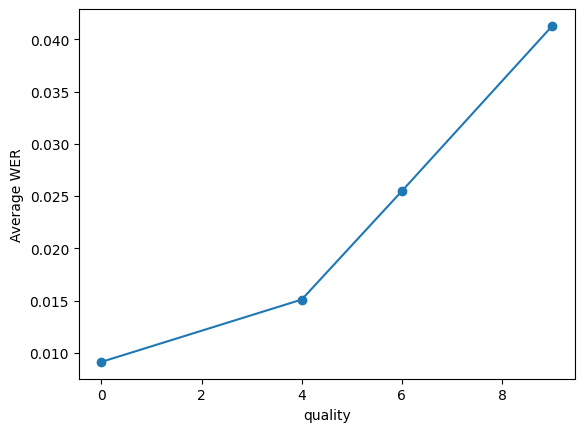

({9.0: {'WER': 0.041273100387526664, 'PESQ': 3.25445525}},
 {9.0: {'WER': [0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.2,
    0.0,
    0.0,
    0.0,
    0.07142857142857142,
    0.0,
    0.2857142857142857,
    0.0,
    0.0,
    0.1,
    0.0,
    0.18181818181818182,
    0.09090909090909091,
    0.03571428571428571,
    0.0,
    0.047619047619047616,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.03571428571428571,
    0.45454545454545453,
    0.03333333333333333,
    0.1,
    0.0,
    0.0,
    0.0,
    0.0625,
    0.0,
    0.07142857142857142,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.4,
    0.14285714285714285,
    0.030303030303030304,
    0.0,
    0.0,
    0.0,
    0.07692307692307693,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0625,
    0.043478260869565216,
    0.2,
    0.0,
    0.0,
    0.09090909090909091,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.

In [6]:



import csv
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

def plot_wer_pesq(output_file_path):
    # Read the output TSV file and extract the data
    with open(output_file_path, "r") as file:
        tsv_file = csv.reader(file, delimiter="\t")
        header = next(tsv_file)  # Skip header row
        data = {column: [] for column in header}
        for line in tsv_file:
            for column, value in zip(header, line):
                data[column].append(value)

    # Convert the data to the appropriate types
    data["WER"] = [float(wer) for wer in data["WER"]]
    data["WER"] = np.clip(data["WER"], 0,2)

    data["PESQ"] = [float(pesq) for pesq in data["PESQ"]]
    data["quality"] = [float(quality) for quality in data["quality"]]


    # Group the data by quality
    grouped_data = {}
    for quality, wer, pesq in zip(data["quality"], data["WER"], data["PESQ"]):
        if quality not in grouped_data:
            grouped_data[quality] = {"WER": [], "PESQ": []}
        grouped_data[quality]["WER"].append(wer)
        grouped_data[quality]["PESQ"].append(pesq)

    # Calculate the average WER and PESQ for each quality
    avg_data = {}
    for quality, quality_data in grouped_data.items():
        avg_wer = np.mean(quality_data["WER"])
        avg_pesq = np.mean(quality_data["PESQ"])
        avg_data[quality] = {"WER": avg_wer, "PESQ": avg_pesq}

    return avg_data, grouped_data

output_file_paths = [
    Path("OUTPUT0quality.tsv"),
    Path("OUTPUT04quality.tsv"),
    Path("OUTPUT6quality.tsv"),
    Path("OUTPUT9quality.tsv"),
]

# Call the plot_wer_pesq function for each file and collect the results
all_avg_data = {}
for output_file_path in output_file_paths:
    avg_data, grouped_data = plot_wer_pesq(output_file_path)
    all_avg_data.update(avg_data)

    # Plot the data for each quality
    for quality, quality_data in grouped_data.items():
        plt.figure()
        plt.suptitle(f"quality {quality}")
        plt.subplot(2, 1, 1)
        plt.plot(quality_data["WER"])
        plt.ylabel("WER")
        plt.subplot(2, 1, 2)
        plt.plot(quality_data["PESQ"])
        plt.xlabel("File")
        plt.ylabel("PESQ")
        plt.show()

# Plot the average WER data for all qualitys
qualitys = list(all_avg_data.keys())
avg_wers = [data["WER"] for data in all_avg_data.values()]

# Call the plot_wer_pesq function for each file and collect the results
all_avg_data = {}
for output_file_path in output_file_paths:
    avg_data, grouped_data = plot_wer_pesq(output_file_path)
    all_avg_data.update(avg_data)

    # Plot the data for each quality
    # (same as before)

# Plot the average WER data for all qualitys
qualitys = list(all_avg_data.keys())
avg_wers = [data["WER"] for data in all_avg_data.values()]


# Plot the average PESQ data for all qualitys
avg_pesqs = [data["PESQ"] for data in all_avg_data.values()]

plt.figure()
plt.plot(qualitys, avg_pesqs, 'o-')
plt.xlabel("quality")
plt.ylabel("Average PESQ")
plt.show()

plt.figure()
plt.plot(qualitys, avg_wers, 'o-')
plt.xlabel("quality")
plt.ylabel("Average WER")
plt.show()

output_file_path = Path("OUTPUT0quality.tsv")
output_file_path1 = Path("OUTPUT04quality.tsv")
output_file_path2 = Path("OUTPUT6quality.tsv")
output_file_path3 = Path("OUTPUT9quality.tsv")

plot_wer_pesq(output_file_path)
plot_wer_pesq(output_file_path1)
plot_wer_pesq(output_file_path2)
plot_wer_pesq(output_file_path3)

